# Phase-Based Tactical Analytics Toolkit
## SkillCorner × PySport Analytics Cup Submission

**Author:** Hamza Adhnan Shakir  
**Date:** December 2025  
**Repository:** [github.com/hamza-shakir/analytics_cup_analyst](https://github.com/hamza-shakir/analytics_cup_analyst)

---

## 1. The Problem

When the scoreline changes, tactics change. But how?

Taking the lead provides structural advantage—teams can sit deeper, absorb pressure, exploit transitions. Conceding forces urgency—opponents push higher, commit bodies forward, accept defensive risk. What's overlooked is the duality: both sides adapt simultaneously.

The team that scores faces a choice: maintain aggression or shift to game management? The trailing team confronts mounting pressure: maintain structure or abandon shape in desperation? Responses vary dramatically.

Standard analytics miss this. Whole-match averages treat 90 minutes as uniform. Even basic game state splits barely scratch the surface.

This toolkit provides granularity: **in-possession vs out-of-possession phases**, **time-segmented analysis**, **score-differential contexts**. Instant segmentation revealing how teams *actually* respond under pressure.

## 2. What This Toolkit Does

Instead of whole-match averages, analyze teams in context:

**Segment by game state** → Compare "when winning" vs "when losing" automatically  
**Filter by possession** → Isolate attacking (IP) or defending (OOP) shapes  
**Narrow by time** → First half, last 10 minutes, 5 minutes after conceding  
**Stack filters** → "High press when 2-0 down in final third" in one line  
**Calculate metrics** → Team positions, compactness, defensive line height, attacking channels

All functions accept kloppy TrackingDataset objects—drop into existing PySport workflows.

**A question that took hours of video analysis now takes 30 seconds of code.**

Here's proof—live analysis of Auckland FC vs Wellington Phoenix...

## 3. Live Demonstration: Auckland FC vs Wellington Phoenix

**Match context:** Auckland won 2-1. Let's first see how the score evolved:

In [1]:
import gamestate as gs

# Load match and display score progression
match_id = 1899585

# Show how the score evolved throughout the match
score_prog = gs.score_progression(match_id=match_id)
score_prog

,home_team.name,home_team_score,away_team_score,away_team.name,minute_start,frame_start
0,Auckland FC,0,0,Wellington Phoenix FC,0,12
1,Auckland FC,1,0,Wellington Phoenix FC,31,18940
2,Auckland FC,2,0,Wellington Phoenix FC,69,44380
3,Auckland FC,2,1,Wellington Phoenix FC,81,51899


```
Score Progression for Match 1899585:
0-0  | 0-31 min   (31 min duration)
1-0  | 31-69 min  (38 min duration)
2-0  | 69-81 min  (12 min duration)
2-1  | 81-90 min  (9 min duration)
```

This score progression provides ideal conditions for analyzing tactical responses to changing game states.

In [2]:
import matplotlib.pyplot as plt

# Now segment the match into key phases based on score changes

# Phase 1: 0-0 (both teams executing original game plans)
baseline = gs.segment_by_time_window(match_id=match_id, start_minute=0, end_minute=31)

# Phase 2: 1-0 Auckland (38 minutes of comfortable lead)
one_nil_lead = gs.segment_by_time_window(match_id=match_id, start_minute=31, end_minute=69)

# Phase 3: 2-1 Auckland (final 9 minutes after Wellington scored)
nervous_lead = gs.segment_by_time_window(match_id=match_id, start_minute=81, end_minute=90)

### Discovery 1: Auckland's Strategic Adjustment

When Auckland took the lead, how did their tactics change?

In [3]:
# Compare Auckland's tactical metrics between baseline (0-0) and established lead (1-0)

# Calculate team shape metrics for baseline phase
comp_baseline = gs.team_compactness(segment=baseline, team='home', match_id=match_id)
line_baseline = gs.defensive_line_height(segment=baseline, team='home', match_id=match_id)
chan_baseline = gs.channel_progression(segment=baseline, team='home', match_id=match_id)

# Calculate same metrics for 1-0 lead phase
comp_one_nil = gs.team_compactness(segment=one_nil_lead, team='home', match_id=match_id)
line_one_nil = gs.defensive_line_height(segment=one_nil_lead, team='home', match_id=match_id)
chan_one_nil = gs.channel_progression(segment=one_nil_lead, team='home', match_id=match_id)

# Display comparison
print("Auckland 0-0:")
print(f"  Width: {comp_baseline['width']:.1f}m | Depth: {comp_baseline['depth']:.1f}m | Def Line: {line_baseline['avg_defensive_line_x']:.1f}m")
print(f"  Channels - L:{chan_baseline['left_pct']:.0f}% C:{chan_baseline['center_pct']:.0f}% R:{chan_baseline['right_pct']:.0f}%")

print("\nAuckland 1-0:")
print(f"  Width: {comp_one_nil['width']:.1f}m | Depth: {comp_one_nil['depth']:.1f}m | Def Line: {line_one_nil['avg_defensive_line_x']:.1f}m")
print(f"  Channels - L:{chan_one_nil['left_pct']:.0f}% C:{chan_one_nil['center_pct']:.0f}% R:{chan_one_nil['right_pct']:.0f}%")

Auckland 0-0:
  Width: 35.9m | Depth: 27.6m | Def Line: -11.3m
  Channels - L:26% C:39% R:34%

Auckland 1-0:
  Width: 35.7m | Depth: 55.3m | Def Line: -13.3m
  Channels - L:39% C:28% R:33%


```
Auckland 0-0:
  Width: 35.9m | Depth: 27.6m | Def Line: -11.3m
  Channels - L:26% C:39% R:34%

Auckland 1-0:
  Width: 35.7m | Depth: 55.3m | Def Line: -13.3m
  Channels - L:39% C:28% R:33%
```

**Insight:** Auckland's tactical response was immediate and dramatic. They maintained team width (35.9m → 35.7m) but doubled their depth (27.6m → 55.3m), stretching the pitch vertically. Their defensive line dropped 2 meters deeper (-11.3m → -13.3m), and they shifted from central penetration (39%) to wider attacks (72% combined wings). This is a coached adjustment: make the pitch big, control possession wide, force opponents to commit forward.

### Discovery 2: Wellington's Desperation Arc

How did Wellington respond as the deficit grew?

In [4]:
# Track Wellington's tactical evolution across three phases as deficit grows

# Segment Wellington's phases
wellington_baseline = gs.segment_by_time_window(match_id=match_id, start_minute=0, end_minute=31)
wellington_one_down = gs.segment_by_time_window(match_id=match_id, start_minute=31, end_minute=69)
wellington_two_down = gs.segment_by_time_window(match_id=match_id, start_minute=69, end_minute=81)

# Collect phases and labels for loop
phases = [wellington_baseline, wellington_one_down, wellington_two_down]
labels = ["0-0", "0-1 Down", "0-2 Down"]

# Calculate and display metrics for each phase
for phase, label in zip(phases, labels):
    comp = gs.team_compactness(segment=phase, team='away', match_id=match_id)
    line = gs.defensive_line_height(segment=phase, team='away', match_id=match_id)
    print(f"Wellington {label}: Width {comp['width']:.1f}m | Def Line {line['avg_defensive_line_x']:.1f}m")

Wellington 0-0: Width 31.1m | Def Line -24.5m
Wellington 0-1 Down: Width 32.7m | Def Line -24.4m
Wellington 0-2 Down: Width 38.6m | Def Line -20.4m


```
Wellington 0-0: Width 31.1m | Def Line -24.5m
Wellington 0-1 Down: Width 32.7m | Def Line -24.4m
Wellington 0-2 Down: Width 38.6m | Def Line -20.4m
```

🔍 Debug: ncols=3, figwidth=18.0, scale=0.577, marker_size=576
🔍 Debug: ncols=3, figwidth=18.0, scale=0.577, marker_size=576
🔍 Debug: ncols=3, figwidth=18.0, scale=0.577, marker_size=576


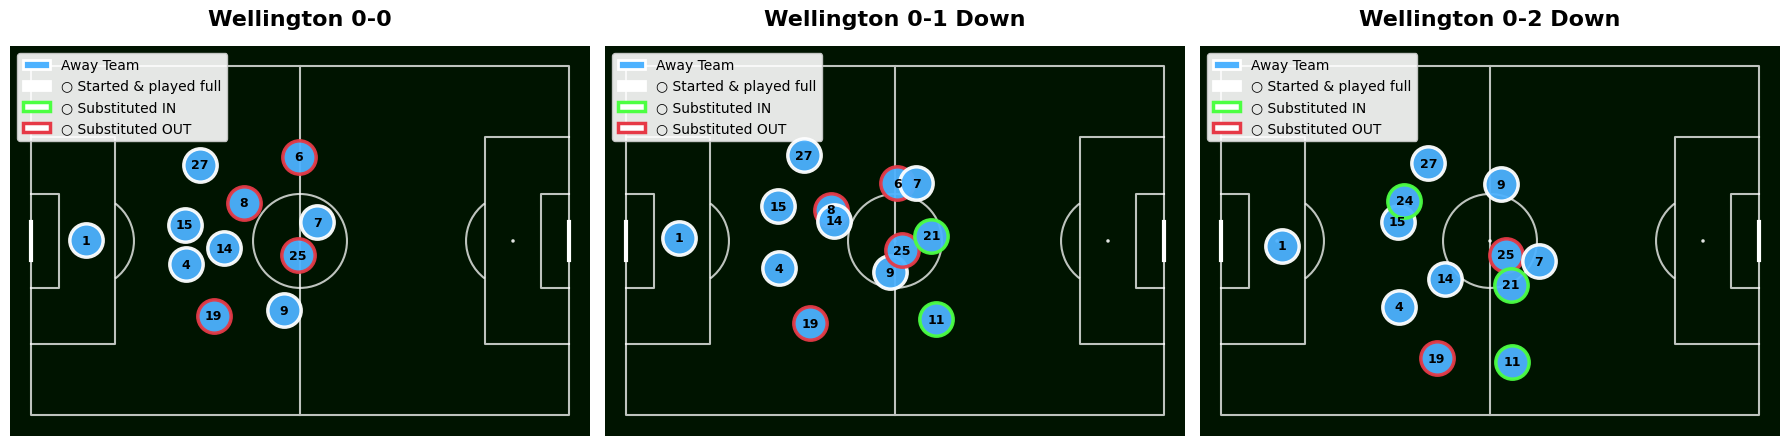

In [5]:
# Generate 3-panel visualization showing Wellington's progressive shape changes

# Calculate average player positions for each phase
positions_wel_0 = gs.average_positions(segment=wellington_baseline, team='away', match_id=match_id)
positions_wel_1 = gs.average_positions(segment=wellington_one_down, team='away', match_id=match_id)
positions_wel_2 = gs.average_positions(segment=wellington_two_down, team='away', match_id=match_id)

# Create side-by-side comparison plot
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
gs.plot_average_positions(positions_df=positions_wel_0, title="Wellington 0-0", ax=ax1, ncols=3, nrows=1)
gs.plot_average_positions(positions_df=positions_wel_1, title="Wellington 0-1 Down", ax=ax2, ncols=3, nrows=1)
gs.plot_average_positions(positions_df=positions_wel_2, title="Wellington 0-2 Down", ax=ax3, ncols=3, nrows=1)
plt.tight_layout()
plt.show()

**Insight:** Wellington's tactical desperation escalates visibly. From 0-0 to 0-2, their width expands by 7.5 meters (31.1m → 38.6m) as they desperately stretch for attacking opportunities. When 0-2 down, they push their defensive line 4 meters higher (-24.5m → -20.4m), taking substantial risks. This progressive expansion creates the exact spaces Auckland exploited with their wide attacks—Wellington's desperation played into Auckland's hands.

### Discovery 3: The Momentum Test

This is the critical test: when Wellington pulled one back (2-1), did momentum force Auckland into reactive chaos?

In [6]:
# The critical test: did Auckland stay composed or panic after Wellington scored?

# Define the two phases for comparison
comfortable = gs.segment_by_time_window(match_id=match_id, start_minute=31, end_minute=69)  # 1-0, 38 minutes
nervous = gs.segment_by_time_window(match_id=match_id, start_minute=81, end_minute=90)      # 2-1, 9 minutes

# Calculate comprehensive metrics for comfortable phase
comp_comfortable = gs.team_compactness(segment=comfortable, team='home', match_id=match_id)
line_comfortable = gs.defensive_line_height(segment=comfortable, team='home', match_id=match_id)
chan_comfortable = gs.channel_progression(segment=comfortable, team='home', match_id=match_id)

# Calculate same metrics for nervous phase
comp_nervous = gs.team_compactness(segment=nervous, team='home', match_id=match_id)
line_nervous = gs.defensive_line_height(segment=nervous, team='home', match_id=match_id)
chan_nervous = gs.channel_progression(segment=nervous, team='home', match_id=match_id)

# Display the comparison
print("Auckland 1-0 Lead (Comfortable, 38 minutes):")
print(f"  Width: {comp_comfortable['width']:.1f}m | Depth: {comp_comfortable['depth']:.1f}m")
print(f"  Def Line: {line_comfortable['avg_defensive_line_x']:.1f}m")
print(f"  Channels - L:{chan_comfortable['left_pct']:.0f}% C:{chan_comfortable['center_pct']:.0f}% R:{chan_comfortable['right_pct']:.0f}%")

print("\nAuckland 2-1 Lead (Nervous, 9 minutes):")
print(f"  Width: {comp_nervous['width']:.1f}m | Depth: {comp_nervous['depth']:.1f}m")
print(f"  Def Line: {line_nervous['avg_defensive_line_x']:.1f}m")
print(f"  Channels - L:{chan_nervous['left_pct']:.0f}% C:{chan_nervous['center_pct']:.0f}% R:{chan_nervous['right_pct']:.0f}%")

Auckland 1-0 Lead (Comfortable, 38 minutes):
  Width: 35.7m | Depth: 55.3m
  Def Line: -13.3m
  Channels - L:39% C:28% R:33%

Auckland 2-1 Lead (Nervous, 9 minutes):
  Width: 36.9m | Depth: 29.9m
  Def Line: -15.3m
  Channels - L:48% C:19% R:34%


```
Auckland 1-0 Lead (Comfortable, 38 minutes):
  Width: 35.7m | Depth: 55.3m
  Def Line: -13.3m
  Channels - L:39% C:28% R:33%

Auckland 2-1 Lead (Nervous, 9 minutes):
  Width: 36.9m | Depth: 29.9m
  Def Line: -15.3m
  Channels - L:48% C:19% R:34%
```

🔍 Debug: ncols=2, figwidth=14.0, scale=0.637, marker_size=637
🔍 Debug: ncols=2, figwidth=14.0, scale=0.637, marker_size=637


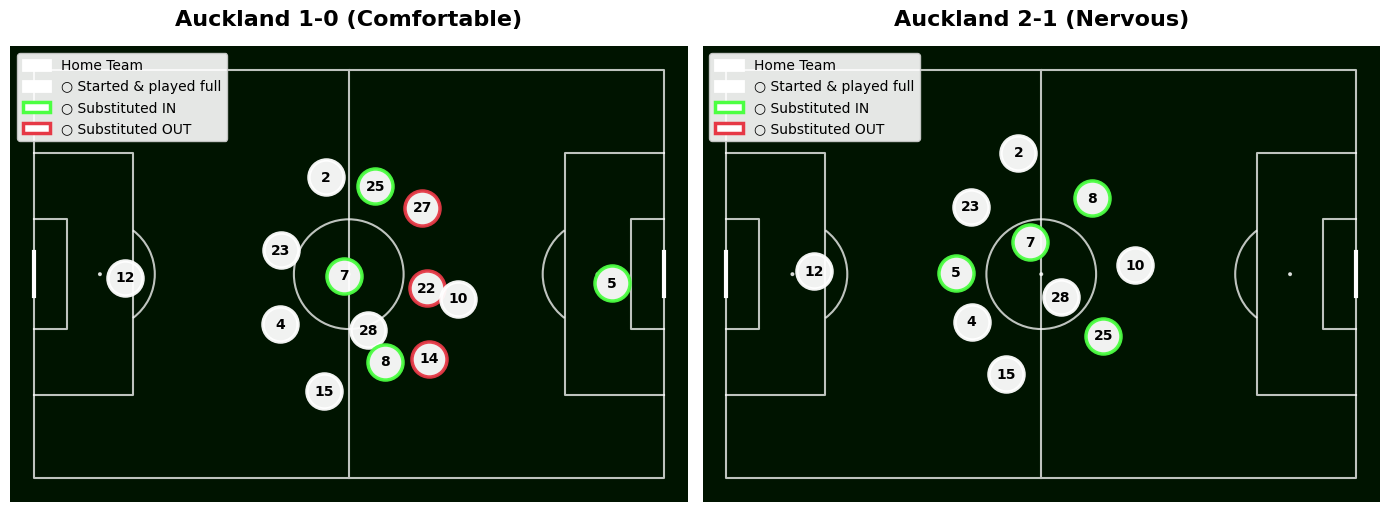

In [7]:
# Visualize the dramatic shape change - the moment of truth

# Get average positions for both phases
positions_comfortable = gs.average_positions(segment=comfortable, team='home', match_id=match_id)
positions_nervous = gs.average_positions(segment=nervous, team='home', match_id=match_id)

# Create side-by-side comparison showing composed vs panicked shape
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
gs.plot_average_positions(positions_df=positions_comfortable, title="Auckland 1-0 (Comfortable)", ax=ax1, ncols=2, nrows=1)
gs.plot_average_positions(positions_df=positions_nervous, title="Auckland 2-1 (Nervous)", ax=ax2, ncols=2, nrows=1)
plt.tight_layout()
plt.show()

**The verdict:** Auckland did NOT stay composed. Their carefully constructed shape collapsed. Depth plummeted from 55.3m to 29.9m—they lost the stretched pitch that had been controlling the game. Their defensive line dropped another 2 meters deeper (-13.3m → -15.3m), and their attacking pattern became lopsided (48% left-sided, only 19% central)—hallmarks of disorganized, reactive play.

This validates the opening premise perfectly: momentum swings can force even winning teams into chaotic responses. Auckland went from controlled dominance to survival mode in the span of one goal.

### What Else Can Be Discovered

This 5-minute analysis revealed four tactical patterns. The toolkit enables much deeper investigation:

**Possession Context Analysis:**
- How did Auckland's width differ when attacking (IP) vs defending (OOP) in each phase?
- Did Wellington's desperation show more in their attacking or defensive shape?
- Compare team compactness in-possession versus out-of-possession across game states

**Tactical Phase Filtering:**
- Isolate build-up patterns from the defensive third when winning
- Compare high press attempts when 0-2 down versus when drawing
- Track transition moments immediately after losing possession
- Analyze final third entries across different game states

**Time-Based Patterns:**
- Compare first 15 minutes versus final 15 minutes of each phase
- Analyze 5-minute windows around each goal for immediate responses
- Track halftime adjustments (0-45 min vs 45-90 min)

**Compositional Analysis:**
- "Defensive third build-up when winning while in possession"
- "High defensive line when losing while out of possession"
- Stack any combination: game state + possession context + tactical phase + time window
- Create custom scenarios matching specific coaching questions

**Visualization Options:**
- Every metric calculated can be visualized—defensive line height evolution, channel progression changes, compactness heatmaps
- Generate publication-ready plots for any filtered segment
- Create side-by-side comparisons across game states, teams, or time periods

The toolkit's compositional design means any tactical question becomes a filter combination—no new code required, just different function chains.

## 4. Conclusion

This toolkit transforms game state analysis from hours of manual video review to minutes of code. The Auckland-Wellington demonstration revealed tactical patterns invisible in whole-match averages: Auckland's coached depth adjustment when ahead, Wellington's progressive desperation, and most tellingly, Auckland's reactive collapse after conceding—validating that momentum swings affect even winning teams.

The core innovation is compositional filtering. Questions don't require new features—they become filter combinations. "How does Team X build up from the defensive third when losing while in possession?" is three function calls. Analysts can investigate any tactical scenario by stacking game state, possession context, tactical phase, and time filters.

Built on kloppy TrackingDataset objects, the toolkit integrates seamlessly into existing PySport workflows. All capabilities demonstrated here—segmentation, metrics, visualizations—work with any match in the SkillCorner dataset.

The tool doesn't prescribe what teams "should" do. It reveals what they actually do, enabling analysts to discover patterns rather than validate assumptions.

---

**Submission for SkillCorner × PySport Analytics Cup**  
**Repository:** [github.com/hamza-shakir/analytics_cup_analyst](https://github.com/hamza-shakir/analytics_cup_analyst)